In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import bokeh
from bokeh.layouts import Row, column, gridplot
from bokeh.models import Title, Legend, TapTool, Range1d, TabPanel, Tabs
import matplotlib as mpl

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import Span


In [2]:
color_palette = [  '#4E79A7',  # Blue
    '#F28E2B',  # Orange
    '#E15759',  # Red
    '#76B7B2',  # Teal
    '#59A14F',  # Green
    '#EDC948',  # Yellow
    '#B07AA1',  # Purple
    '#FF9DA7',  # Pink
    '#9C755F',  # Brown
    '#BAB0AC',  # Gray
    '#7C7C7C',  # Dark gray
    '#6B4C9A',  # Violet
    '#D55E00',  # Orange-red
    '#CC61B0',  # Magenta
    '#0072B2',  # Bright blue
    '#329262',  # Peacock green
    '#9E5B5A',  # Brick red
    '#636363',  # Medium gray
    '#CD9C00',  # Gold
    '#5D69B1',  # Medium blue
]

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# fig, ax = plt.subplots(figsize=(12,6))
# plt.rcParams["font.family"] = "Arial"

def get_fig(acled, start_date = None, end_date=None, title=None, ax=ax, fig=fig):

    if start_date is not None:
        df = acled[(acled['event_date']>start_date)&(acled['event_date']<end_date)]
    else:
        df = acled
    
    vmin = 0
    vmax = 1050

    df = df.groupby([pd.Grouper(key='event_date', freq='Y', closed='left')]+['latitude', 'longitude'])['fatalities'].agg(['sum', 'count']).reset_index()
    df.rename(columns = {'sum':'fatalities', 'count':'nrEvents'}, inplace=True)

    df = convert_to_gdf(df)

    #syria_adm3.boundary.plot(ax=ax, color = '#d3d3d3')
    p1 = df.plot(column='nrEvents', cmap = 'Reds', ax=ax, vmin=vmin, vmax=vmax)
    #turkey_adm2.boundary.plot(ax=ax, edgecolor = '#D3D3D3', linewidth=0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])

    if title is not None:
        ax.set_title(title)



    sm = plt.cm.ScalarMappable(cmap='Reds',norm=plt.Normalize(vmin=vmin, vmax=vmax))


    divider = make_axes_locatable(ax)
    dvider_kwargs = dict(position="left", size="1.5%", pad=0)
    fig.colorbar(sm, cax=divider.append_axes(**dvider_kwargs),
                #format = matplotlib.ticker.FuncFormatter(lambda x, pos: ''),
                #ticks = matplotlib.ticker.FixedLocator([])
                )

    return p1

In [6]:
bokeh.core.validation.silence(EMPTY_LAYOUT, True)

def get_line_plot(ooklaUsers,title, source, earthquakes=False, subtitle=None, measure = 'conflictIndex', category = 'ADM4_EN'):

    p2 = figure(x_axis_type = 'datetime', width = 1000, height = 400, toolbar_location='above')
    p2.add_layout(Legend(), "right")

    for id, adm2 in enumerate(ooklaUsers[category].unique()):
        df = ooklaUsers[ooklaUsers[category]==adm2][['event_date', measure]].reset_index(drop=True)
        p2.line(df['event_date'], df[measure], line_width=2, line_color = color_palette[id], legend_label=adm2)

    p2.legend.click_policy='hide'
    if subtitle is not None:
        p2.title = subtitle


    title_fig = figure(title=title, toolbar_location=None,width=800, height=40, )
    title_fig.title.align = "left"
    title_fig.title.text_font_size = "20pt"
    title_fig.border_fill_alpha = 0
    title_fig.outline_line_width=0

    #with silence(MISSING_RENDERERS):
    sub_title = figure(title=source, toolbar_location=None,width=800, height=40, )
    sub_title.title.align = "left"
    sub_title.title.text_font_size = "10pt"
    sub_title.title.text_font_style="normal"
    sub_title.border_fill_alpha = 0
    sub_title.outline_line_width=0

    layout = column(title_fig, p2, sub_title)

#     if earthquakes:
#         p2.renderers.extend([
#         Span(
#             location=datetime(2020, 3, 15),
#             dimension="height",
#             line_color='#7C7C7C',
#             line_width=2,
#             line_dash=(4,4)
#       ),
#         Span(
#             location=datetime(2021, 2, 15),
#             dimension="height",
#             line_color='#7C7C7C',
#             line_width=2,
#             line_dash=(4,4)
#         ),
#     ]
# )

    return layout

In [7]:
from shapely.geometry import Point

def convert_to_gdf(df):
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

In [8]:
syria_adm3 = gpd.read_file('../../data/shapefiles/syr_pplp_adm4_unocha_20210113/syr_admbnda_adm3_uncs_unocha_20201217.json')
syria_adm4 = gpd.read_file('../../data/shapefiles/syr_pplp_adm4_unocha_20210113/syr_pplp_adm4_unocha_20210113.json')
region_control = pd.read_excel('../../data/shapefiles/IntensityAoC_ADM4_v12.xlsx')
intensity = pd.read_csv('../../data/earthquake-intensity/syria_adm4_earthquake_intensity.csv')
syria_adm4 = syria_adm4.merge(intensity[['ADM1_EN', 'ADM2_EN','ADM3_EN', 'ADM4_EN', 'category_max_feb06', 'max_intensity_feb06']], on = ['ADM1_EN', 'ADM2_EN', 'ADM3_EN', 'ADM4_EN'])

region_control = region_control[['ADM4_EN', 'Population', 'aoc']]
syria_adm4 = syria_adm4.merge(region_control, on = ['ADM4_EN'])

syria_adm2 = gpd.read_file('../../data/shapefiles/syr_pplp_adm4_unocha_20210113/syr_admbnda_adm2_uncs_unocha_20201217.json')

# Armed Conflict Location and Event Data Analysis

The Armed Conflict Location & Event Data Project (ACLED) is a disaggregated data collection, analysis, and crisis mapping project. ACLED collects information on the dates, actors, locations, fatalities, and types of all reported political violence and protest events around the world. The raw data is available through a license obtained by the World Bank

In [9]:
from datetime import datetime

acled = pd.concat([pd.read_csv('../../data/acled/2017-01-01-2023-06-28-Syria.csv'), pd.read_csv('../../data/acled/2023-06-01-2023-10-03-Syria.csv')])
#acled['timestamp'] = acled['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
acled['event_date'] = acled['event_date'].apply(lambda x: datetime.strptime(x, '%d %B %Y'))

In [10]:
syria_adm4_crs = syria_adm4.to_crs('EPSG:32632')
syria_adm3_crs = syria_adm3.to_crs('EPSG:32632')
syria_adm2_crs = syria_adm2.to_crs('EPSG:32632')

## Calculating Conflict Index

Conflict Index is calculated as a geometric mean of conflict events and fatalities at admin 2 level

In [11]:
from scipy.stats import gmean

def get_acled_by_admin(adm, acled, columns = ['ADM4_EN','ADM3_EN','ADM2_EN', 'ADM1_EN'], nearest=False):
    acled_adm2 = convert_to_gdf(acled)
    acled_adm2 = acled_adm2.to_crs('EPSG:32632')
    if nearest == True:
        acled_adm2 = adm.sjoin_nearest(acled_adm2, max_distance=2000)[[ 'event_date', 'fatalities', 'event_type' ]+columns].groupby([pd.Grouper(key='event_date', freq='M', closed='left')]+columns)['fatalities'].agg(['sum', 'count']).reset_index()
    else:
        acled_adm2 = adm.sjoin(acled_adm2)[[ 'event_date', 'fatalities', 'event_type' ]+columns].groupby([pd.Grouper(key='event_date', freq='M', closed='left')]+columns)['fatalities'].agg(['sum', 'count']).reset_index()
    acled_adm2.rename(columns = {'sum':'fatalities', 'count':'nrEvents'}, inplace=True)
    acled_adm2['conflictIndex'] = acled_adm2.apply(lambda row: gmean([row['nrEvents'], row['fatalities']]), axis=1)
    acled_adm2['conflictIndexLog'] = np.log(acled_adm2['conflictIndex'])
    #acled_adm2['event_date_map'] = acled_adm2['event_date'].apply(lambda x: x.date().replace(day=1))

    return acled_adm2.reset_index()

In [12]:
import numpy as np
acled_adm4 = get_acled_by_admin(syria_adm4_crs, acled)
df1 = acled_adm4[acled_adm4['conflictIndex']>0]
df1['conflictIndexLog'] = np.log(df1['conflictIndex'])

In [13]:
acled_adm4 = get_acled_by_admin(syria_adm4_crs, acled, nearest=True)
acled_adm3 = get_acled_by_admin(syria_adm3_crs, acled, columns = ['ADM3_EN','ADM2_EN', 'ADM1_EN'],nearest=True)
acled_aoc = get_acled_by_admin(syria_adm4_crs, acled, columns = ['aoc'],nearest=True)
acled_intensity = get_acled_by_admin(syria_adm4_crs, acled, columns = ['category_max_feb06'],nearest=True)

c:\Users\sahit\anaconda3\envs\turkey-rdna\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\sahit\anaconda3\envs\turkey-rdna\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\sahit\anaconda3\envs\turkey-rdna\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\sahit\anaconda3\envs\turkey-rdna\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
acled_adm4[['event_date', 'ADM1_EN','ADM2_EN', 'ADM3_EN', 'ADM4_EN', 'fatalities', 'nrEvents']].to_csv('../../data/acled/acled_admin4_2017_2023.csv')

In [15]:
import numpy as np

syria_adm0 = gpd.read_file('../../data/shapefiles/syr_pplp_adm4_unocha_20210113/syr_admbnda_adm0_uncs_unocha_20201217.json')
acled_adm0 = get_acled_by_admin(syria_adm0.to_crs('EPSG:32632'), acled, columns = ['ADM0_EN'])

In [17]:
acled = convert_to_gdf(acled)
aug_acled = acled[(acled['event_date']>='2023-08-01')&(acled['event_date']<='2023-08-31')]

In [18]:
import pandas as pd

def normalize_column(df, column_name):

    min_val = df[column_name].min()
    max_val = df[column_name].max()
    
    df[column_name + '_normalized'] = (df[column_name] - min_val) / (max_val - min_val)
    return df


In [19]:
aug_acled = aug_acled.groupby(['latitude', 'longitude'])['fatalities'].agg(['sum', 'count']).reset_index()
aug_acled.rename(columns = {'sum':'fatalities', 'count':'nr_events'}, inplace=True)

In [20]:
aug_acled = normalize_column(aug_acled, 'fatalities')
aug_acled = normalize_column(aug_acled, 'nr_events')

In [21]:
aug_acled = convert_to_gdf(aug_acled)
data = aug_acled.set_index('geometry')['nr_events'].to_dict()

In [79]:
syria_adm1 = gpd.read_file('../../data/shapefiles/syr_pplp_adm4_unocha_20210113/syr_admbnda_adm1_uncs_unocha_20201217.json')

C:\Users\sahit\AppData\Local\Temp\ipykernel_3764\1235515577.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


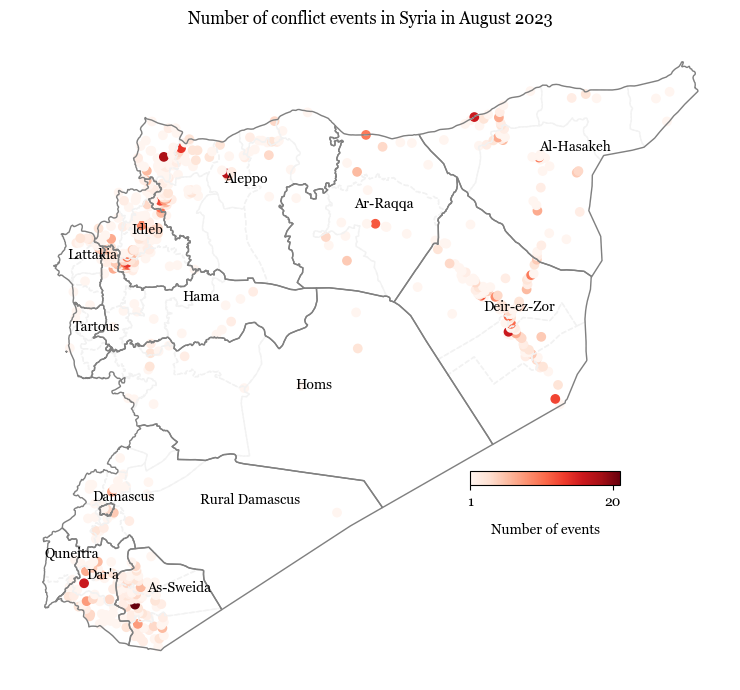

In [93]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import inferno
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams["font.family"] = "Georgia"

# Assuming 'aug_acled' is a GeoDataFrame
data = [[point.xy[1][0], point.xy[0][0], value] for point, value in zip(aug_acled.geometry, aug_acled['nr_events'])]
df = pd.DataFrame(data, columns=['latitude', 'longitude', 'value'])

# Create a custom colormap
# colors = ['#FFC0C0', '#FF8080', '#FF4040', '#FF0000', '#8B0000']
# cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

colors = ['yellow', 'purple']
cmap = 'Reds'#LinearSegmentedColormap.from_list('custom', colors, N=256)

# Plot using matplotlib
fig, ax = plt.subplots(figsize=(10, 7))
# ax.imshow(img_plt, extent=[32, 42, 35, 37], aspect='equal')



# Plot boundary data
syria_adm2.boundary.plot(ax=ax, color='#f2f2f2', linewidth=1, linestyle='--', edgecolor='white')
syria_adm1.boundary.plot(ax=ax, color='grey', linewidth = 1)

for adm1 in syria_adm1['ADM1_EN'].unique():
    x, y =syria_adm1[syria_adm1['ADM1_EN']== adm1]['geometry'].iloc[0].centroid.x, syria_adm1[syria_adm1['ADM1_EN']== adm1]['geometry'].iloc[0].centroid.y

    #ax.scatter(x, y, c='black', marker='', s=50, label=adm1)

# Use the annotate function to add the text to the map
    ax.annotate(adm1, xy=(x-0.3, y-0.05), xytext=(10, 10), textcoords='offset points',
                fontsize=10, color='black')

# syria_adm1.boundary.plot()
aug_acled.plot(column='nr_events', ax=ax, cmap=cmap)

# Set title
ax.set_title("Number of conflict events in Syria in August 2023")
# Create a custom location for the colorbar
cax = fig.add_axes([0.6, 0.3, 0.15, 0.02])


# Display colorbar
norm = plt.Normalize(vmin=df['value'].min(), vmax=df['value'].max())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', pad=0.02, aspect = 200, cax=cax, ticks = [1,20])
cbar.set_label('Number of events', rotation=0, labelpad=10)

# Set axis off
ax.axis('off')

plt.tight_layout()
plt.savefig('../../docs/images/acled_august.png')
plt.show()

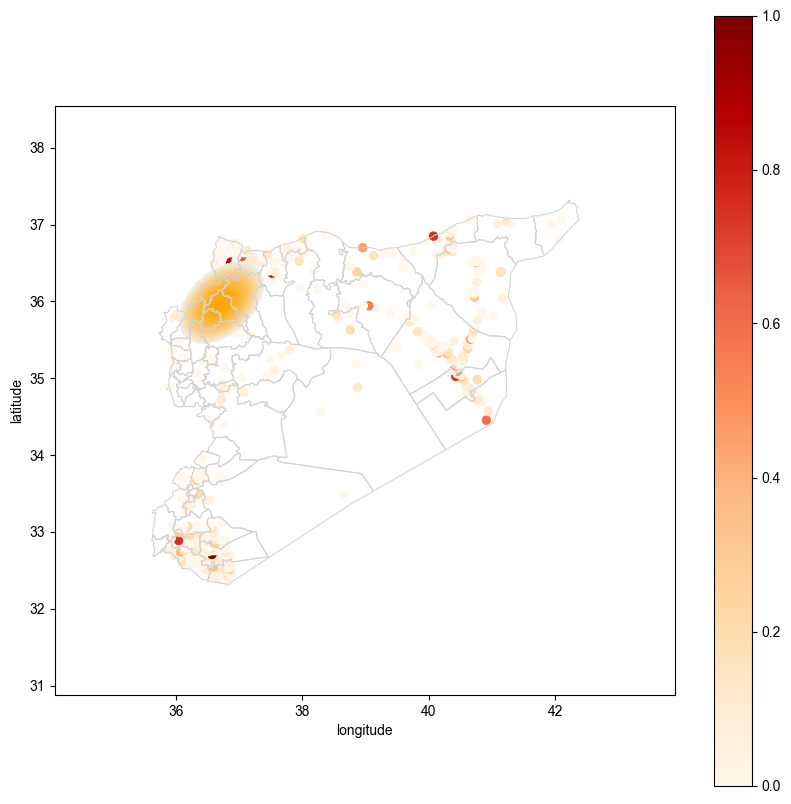

In [106]:
import seaborn as sns

cmap = sns.light_palette("orange", as_cmap=True)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

syria_adm2.boundary.plot(ax=ax, linewidth = 0.8, color = 'lightgrey')
aug_acled.plot(column='nr_events_normalized', cmap='OrRd', linewidth=0.8, ax=ax, legend=True)
sns.kdeplot(
    x=aug_acled['longitude'],
    y=aug_acled['latitude'],
    weights=aug_acled['nr_events_normalized'],
    cmap=cmap,
    fill=True,
    levels=100,
    thresh=0.9,
    ax=ax
)

plt.show()

<Axes: >

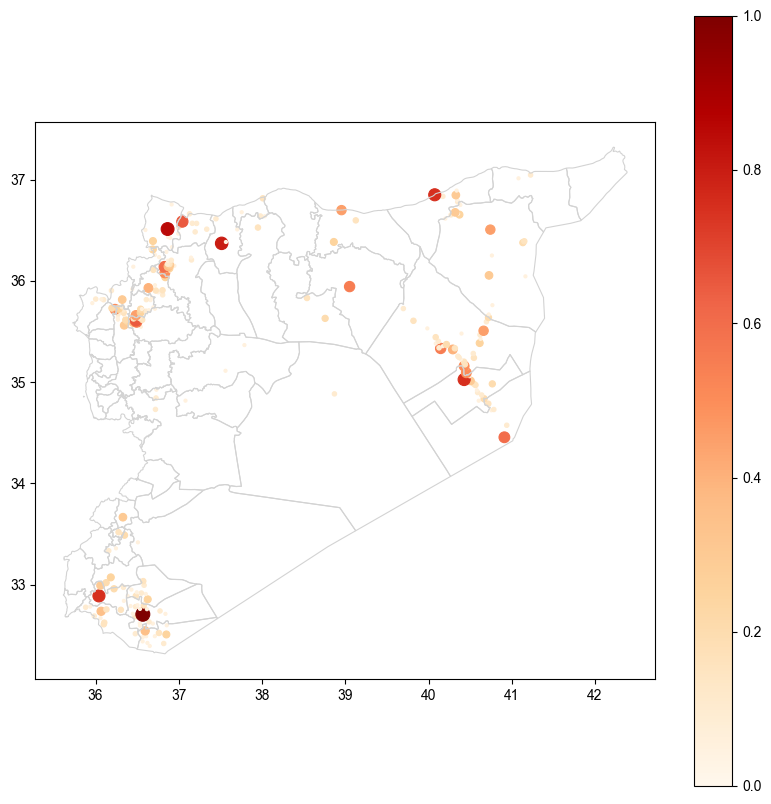

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

syria_adm2.boundary.plot(ax=ax, linewidth = 0.8, color = 'lightgrey')
aug_acled.plot(column='nr_events_normalized', cmap='OrRd', linewidth=0.8, ax=ax, legend=True, markersize=aug_acled['nr_events_normalized']*100)


In [21]:
output_notebook()
acled_adm0 = acled_adm0.groupby(['ADM0_EN', pd.Grouper(key='event_date', freq='M')]).sum(['fatalities', 'nrEvents']).reset_index()
show(get_line_plot(acled_adm0, title = 'National Trends in conflict events', source= 'ACLED', category='ADM0_EN', measure = 'nrEvents'))

Loading BokehJS ...

In [22]:
acled_adm0.groupby(['ADM0_EN', pd.Grouper(key='event_date', freq='Y')]).sum(['fatalities', 'nrEvents']).reset_index()

,ADM0_EN,event_date,index,fatalities,nrEvents,conflictIndex,conflictIndexLog
0,Syrian Arab Republic,2017-12-31,66,54345,31395,41221.880982,97.523622
1,Syrian Arab Republic,2018-12-31,210,29988,20820,24854.683841,90.810144
2,Syrian Arab Republic,2019-12-31,354,15617,20037,17528.538179,87.025012
3,Syrian Arab Republic,2020-12-31,498,8186,12385,10023.405372,80.350493
4,Syrian Arab Republic,2021-12-31,642,5849,10721,7901.533451,77.747495
5,Syrian Arab Republic,2022-12-31,786,5901,12259,8479.471919,78.577275
6,Syrian Arab Republic,2023-12-31,684,4842,9141,6589.771383,58.905973


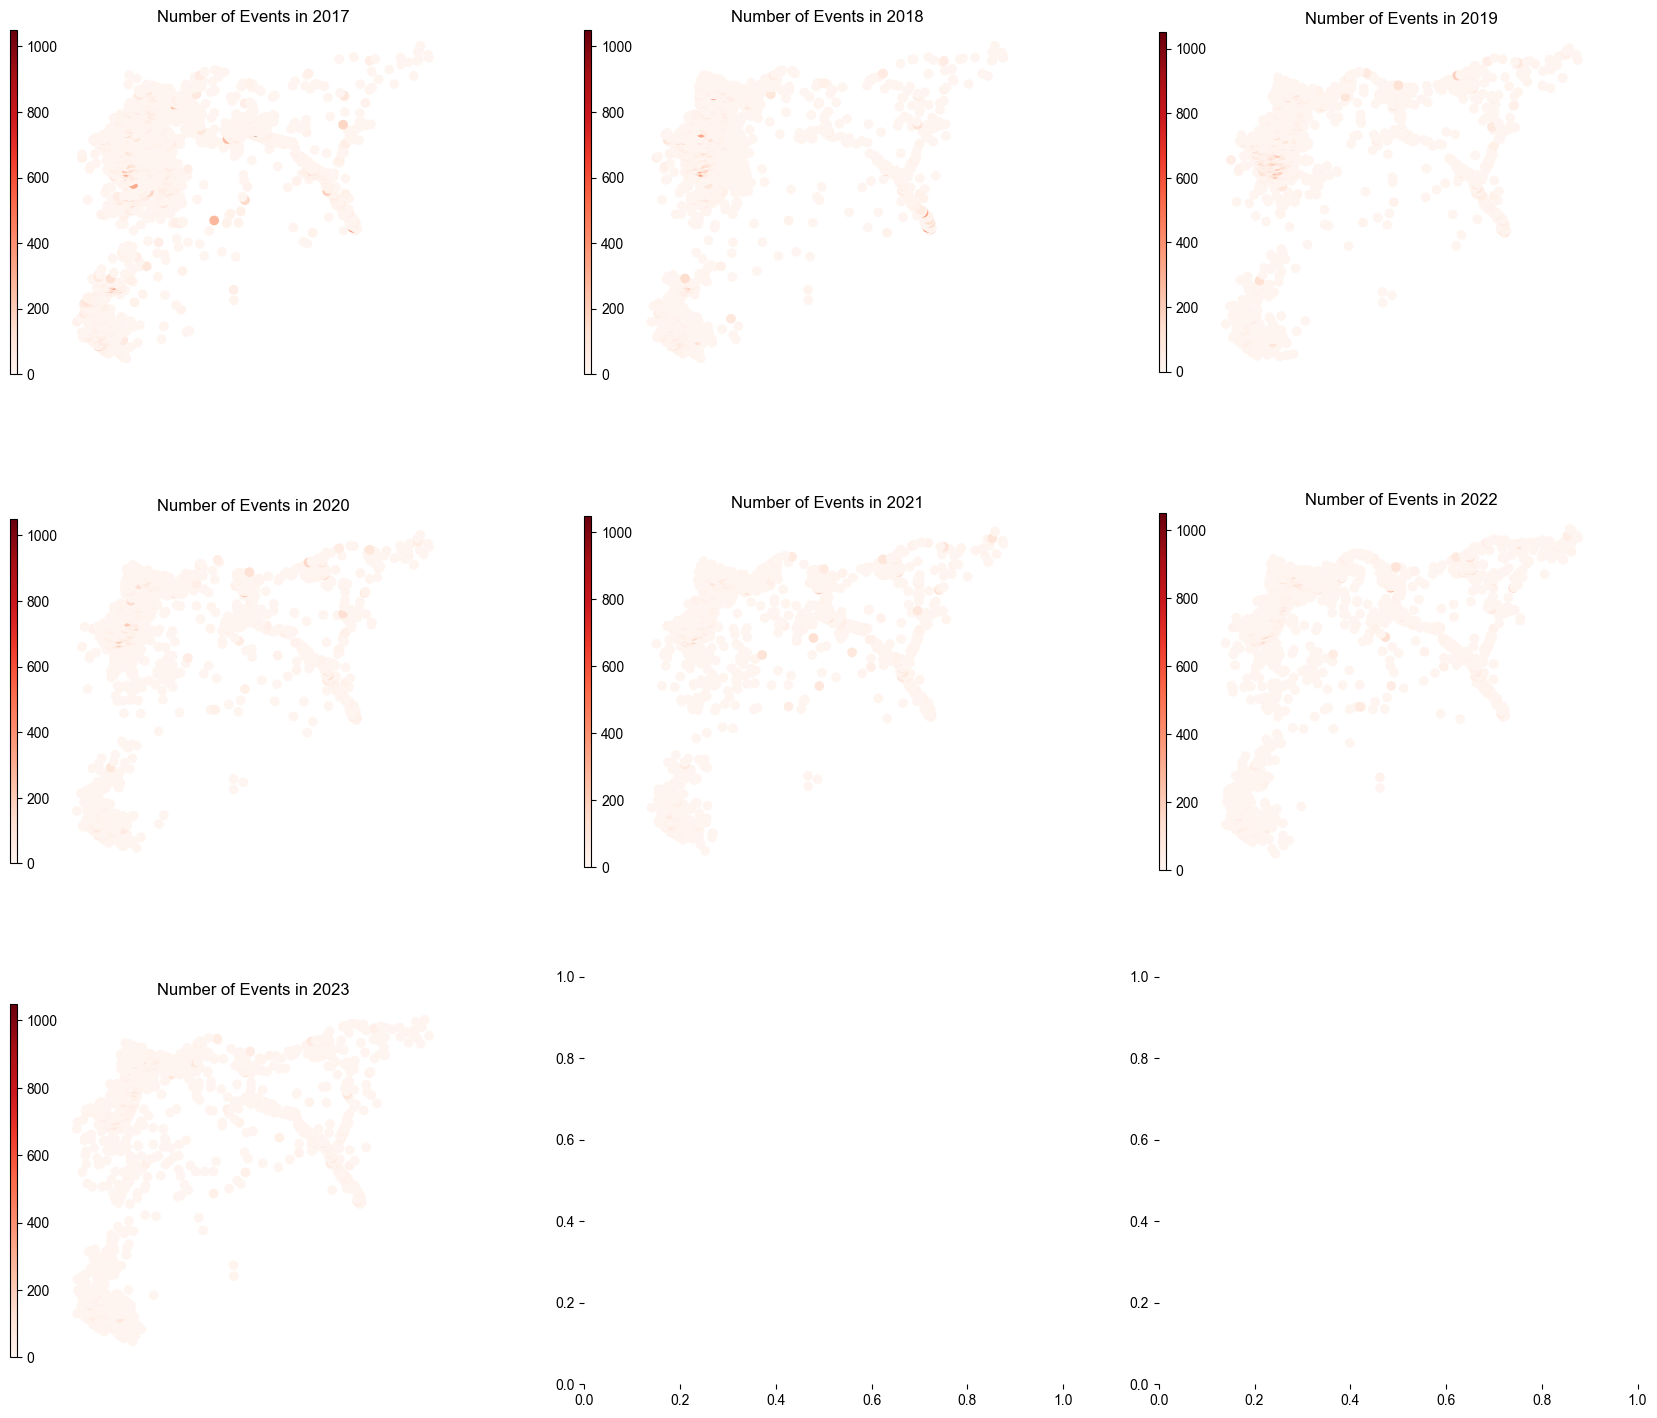

In [23]:
fig, axs = plt.subplots(3,3,figsize=(21,18))
ax=axs.flatten()
for idx, year in enumerate(range(2017, 2024, 1)):
    get_fig(convert_to_gdf(acled), f'{year}-01-01', f'{year}-12-31', f'Number of Events in {year}', ax=ax[idx], fig=fig)

for i in [7,8]:
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
# get_fig(convert_to_gdf(acled), '2022-01-01', '2022-12-31', 'Fatalities in 2022', ax=ax[1], fig=fig)

# get_fig(convert_to_gdf(acled), '2023-01-01', '2023-12-31', 'Fatalities in 2023', fig=fig, ax=ax[2])

# get_fig(convert_to_gdf(acled), '2021-01-01', '2021-12-31', 'Fatalities in 2021', ax=ax[0], fig=fig)
# get_fig(convert_to_gdf(acled), '2022-01-01', '2022-12-31', 'Fatalities in 2022', ax=ax[1], fig=fig)

# get_fig(convert_to_gdf(acled), '2023-01-01', '2023-12-31', 'Fatalities in 2023', fig=fig, ax=ax[2])
#get_fig(acled, '2022-02-05', '2022-03-31', 'Fatalities between 5th February 2022 and 31st March 2022', ax=ax[1])

### Observations

* The number of conflict events in 2022 were higher than in 2021. However, the number of deaths was higher in 2021 and 2020. 
* There is no discernable trend is Ramadaan months of each year
* The spatial spread of conflict also changed significantly over the years with it becoming more concentrated in 2023


In [24]:
output_notebook()

show(get_line_plot(acled_intensity, f"Conflict index by earthquake intensity", "Source: ACLED", earthquakes=True, subtitle = '', category = 'category_max_feb06', measure = 'conflictIndex'))

Loading BokehJS ...

### Observations
It is seen from the below image that earthquake intensity had little to do with conflict intensity in Syria i.e., the areas where there was earthquake impact do not coincide with areas of high conflict. The conflict is agnostic to earthquakes and has peristsed before the earthquake. 

In [25]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

acled_adm2 = get_acled_by_admin(syria_adm2_crs, acled, columns = ['ADM2_EN', 'ADM1_EN'])
for adm in list(acled_adm2['ADM1_EN'].unique()):
    df = acled_adm2[acled_adm2['ADM1_EN']==adm] 

    tabs.append(
        TabPanel(
        child=get_line_plot(df, f"Conflict Index by admin 2", "Source: ACLED", earthquakes=True, subtitle = '', category = 'ADM2_EN', measure = 'conflictIndex'),
                    title=adm.capitalize(),
                )
                )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

c:\Users\sahit\anaconda3\envs\turkey-rdna\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Observations
- The Aleppo and Idleb regions have high conflict compared to the rest of the country
- The conflict has reduced in Aleppo and Idleb over time

In [26]:
output_notebook()
title = 'Monthly conflict related fatalities by Area of Control'
source= 'ACLED'

show(get_line_plot(acled_aoc[acled_aoc['event_date'].dt.year>2016], title = title, source= source, category='aoc'))

Loading BokehJS ...

### Observations
* The conflcit index is the highest in government and allied force controlled areas 
* It used to be much higher in Non state armed group controlled areas but went down significantly in early 2022.